##PROJET: Maintenace Predective



**Objectif du projet** :Construire un modèle de machine learning capable de prédire si une machine va subir une panne (Machine failure = 1) en fonction de ses paramètres techniques.




##Exploratory Data Analysis



**Importation des librairies necessaires**

In [ ]:

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.multiclass import OneVsRestClassifier


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, train_test_split


import joblib


**On importe notre dataset**

In [ ]:
data= pd.read_csv('ai4i2020.csv')


In [ ]:
df=data.copy()

In [ ]:
df.shape


(10000, 14)

On voit que notre data comporte 10000 lignes et 14 colonnes donc 14 features.

**On visualise les  5 premieres lignes de notre dataset**

In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

**Description des features**

* UDI : identifiant unique de chaque ligne (non informatif pour la prédiction).

* Product ID : identifiant du produit, contient un code qualité (L, M, H) + un numéro de série.

* Type : qualité du produit :

    L : qualité basse (50% des données)

    M : qualité moyenne (30%)

    H : qualité haute (20%)

* Air temperature [K] : température ambiante en Kelvin, simulée autour de 300 K.

* Process temperature [K] : température du processus, égale à la température ambiante +10 K, avec une petite variation.

* Rotational speed [rpm] : vitesse de rotation de la machine, bruitée autour de la valeur liée à une puissance de 2860 W.

* Torque [Nm] : couple appliqué pendant le processus, distribué autour de 40 Nm (écart-type 10).

* Tool wear [min] : usure de l’outil en minutes. Dépend de la qualité du produit :

  +2 min pour L,

  +3 min pour M,

  +5 min pour H.

*  Machine failure : étiquette cible (1 si la machine a échoué, sinon 0).

* TWF (Tool Wear Failure) : panne due à l’usure de l’outil (usure trop élevée).

* HDF (Heat Dissipation Failure) : panne due à une mauvaise dissipation de chaleur (si différence de température < 8.6 K et rotation < 1380 rpm).

* PWF (Power Failure) : panne liée à la puissance du système (couple × vitesse angulaire en dehors de [3500, 9000] W).

* OSF (Overstrain Failure) : surcharge de la machine (produit de l’usure et du couple trop élevé selon le type).

* RNF (Random Failure) : panne aléatoire (0.1 % de probabilité, indépendamment des autres conditions).

**Les types de variables:**

In [ ]:
df.dtypes

,0
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Machine failure,int64
TWF,int64


<Axes: ylabel='count'>

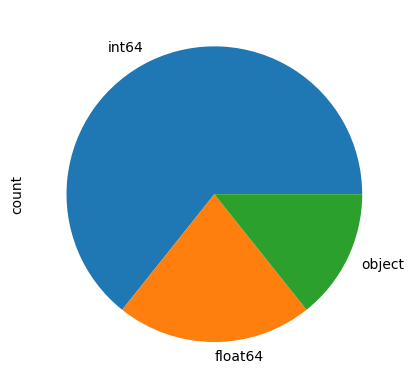

In [ ]:
df.dtypes.value_counts().plot.pie()

On verifie s'il ya de valeurs manquantes

In [ ]:
df.isna().sum()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Machine failure,0
TWF,0


Il ny a pas de valeurs manquantes

**On elimine les colonnes non neessaires**

In [ ]:
df.drop(columns=['UDI','Product ID'],inplace=True)

Examen de la colonne target

In [ ]:
df["Machine failure"].value_counts()

,count
Machine failure,
0,9661
1,339


In [ ]:
df["Machine failure"].value_counts(normalize=True)

,proportion
Machine failure,
0,0.9661
1,0.0339


Donc c'est juste 3% des cas sont des machines failures , notre dataset est déséquilibré

**Examen de type de pannes**

In [ ]:

total_failures = df['Machine failure'].sum()

failure_percent = (df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum() / total_failures * 100).round(2)
failure_percent_df = failure_percent.reset_index()
failure_percent_df.columns = ['Type de panne', 'Pourcentage (%)']
failure_percent_df = failure_percent_df.sort_values(by='Pourcentage (%)', ascending=False)

print(failure_percent_df)


  Type de panne  Pourcentage (%)
1           HDF            33.92
3           OSF            28.91
2           PWF            28.02
0           TWF            13.57
4           RNF             5.60


**Répartition des types de produits**

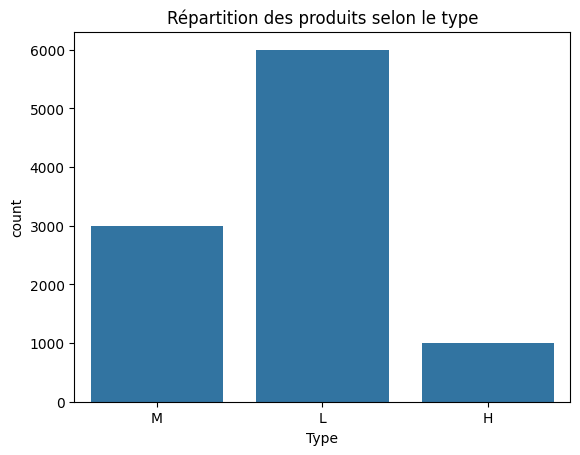

Type
L    60.00
M    29.97
H    10.03
Name: proportion, dtype: float64


In [ ]:

sns.countplot(data=df, x='Type')
plt.title("Répartition des produits selon le type")
plt.show()


print(df['Type'].value_counts(normalize=True) * 100)

###Distribution des variables numériques

Pour observer la distribution (forme,
étalement, outliers) de chaque variable continue

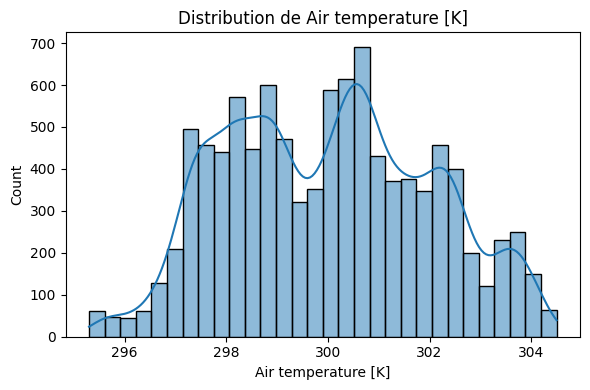

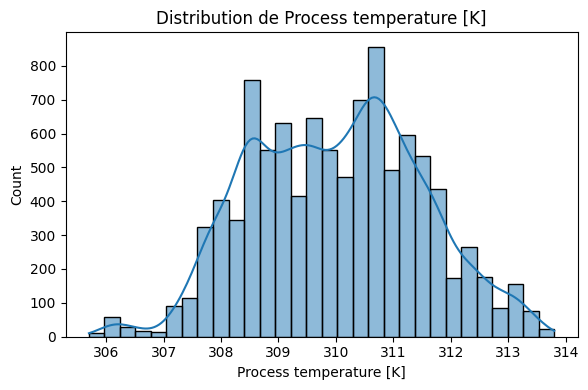

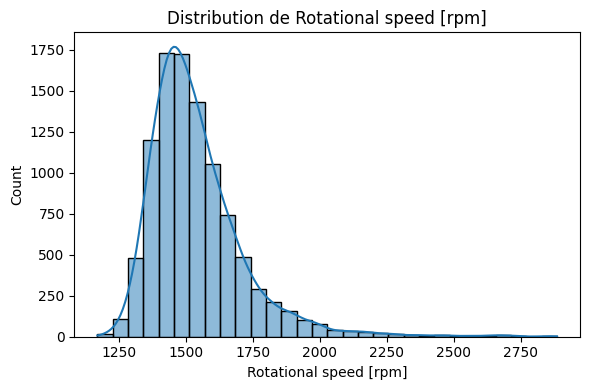

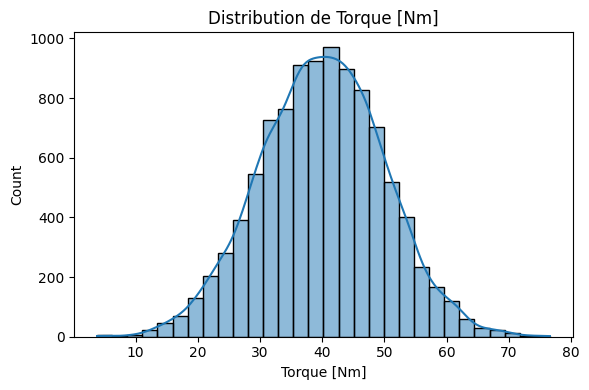

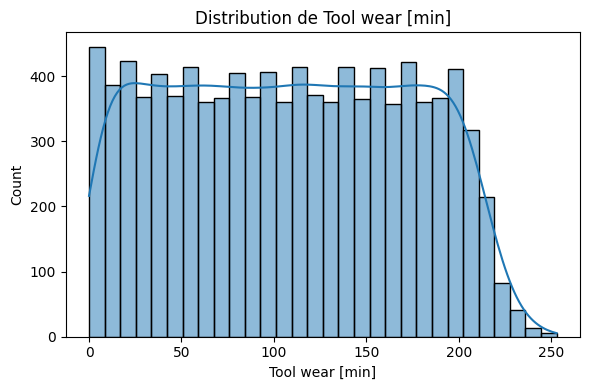

In [ ]:
for col in ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f"Distribution de {col}")
    plt.tight_layout()
    plt.show()

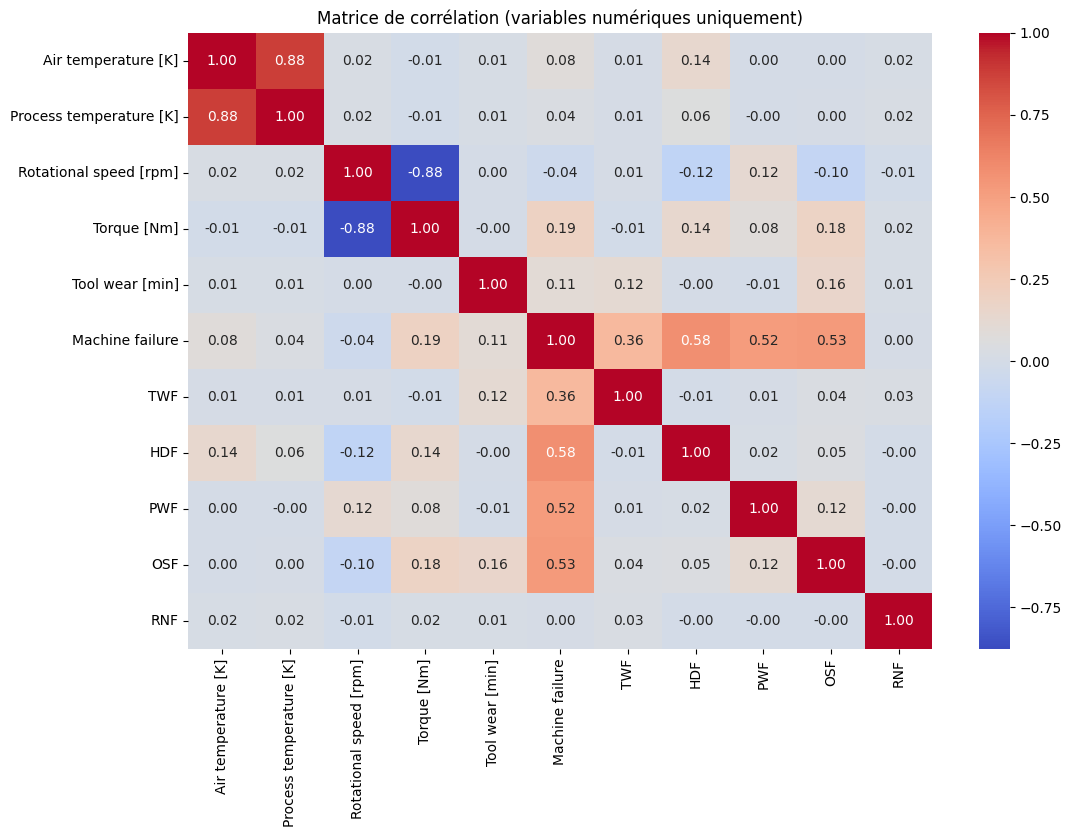

In [ ]:

numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation (variables numériques uniquement)")
plt.show()


Aucune variable n’a une forte corrélation directe avec Machine failure,
cela indique que les pannes sont multi-causes, pas déclenchées par une seule variable

###Visualisation des conditions physiques liées aux pannes

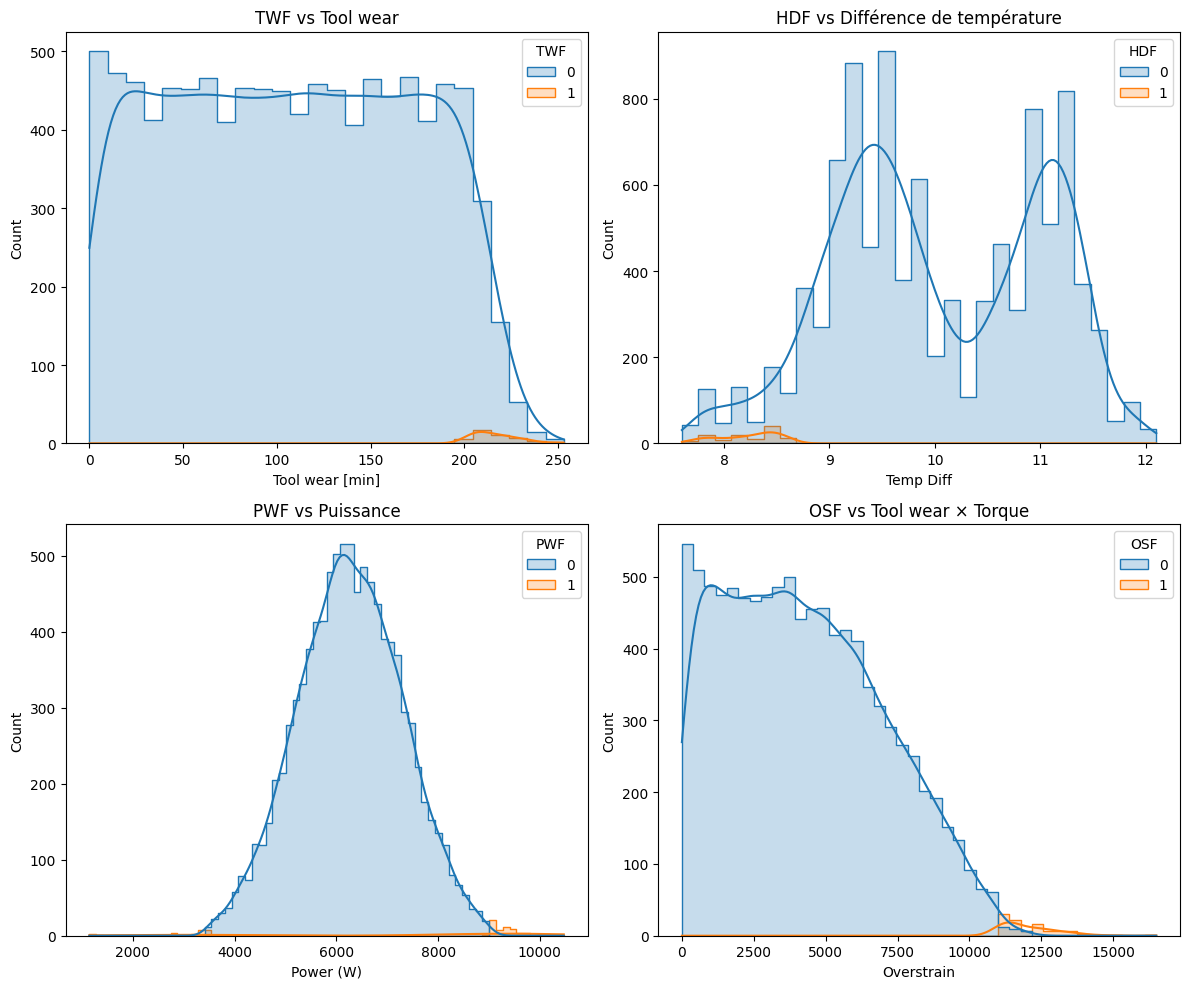

In [ ]:



df['Temp Diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
df['Rotational speed [rad/s]'] = df['Rotational speed [rpm]'] * (2 * np.pi / 60)
df['Power (W)'] = df['Torque [Nm]'] * df['Rotational speed [rad/s]']
df['Overstrain'] = df['Tool wear [min]'] * df['Torque [Nm]']


plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df, x='Tool wear [min]', hue='TWF', kde=True, element='step')
plt.title("TWF vs Tool wear")

plt.subplot(2, 2, 2)
sns.histplot(data=df, x='Temp Diff', hue='HDF', kde=True, element='step')
plt.title("HDF vs Différence de température")

plt.subplot(2, 2, 3)
sns.histplot(data=df, x='Power (W)', hue='PWF', kde=True, element='step')
plt.title("PWF vs Puissance")

plt.subplot(2, 2, 4)
sns.histplot(data=df, x='Overstrain', hue='OSF', kde=True, element='step')
plt.title("OSF vs Tool wear × Torque")

plt.tight_layout()
plt.show()


1. TWF vs Tool wear [min]
Tool Wear Failure = panne par usure de l’outil

On observe que les cas TWF = 1 (en orange) sont concentrés autour de 200–240 min, ce qui confirme la règle métier.

Le reste de la population (bleu) est très majoritairement en dessous de ce seuil.  Conclusion : cohérence avec la logique métier — la panne survient quand l’usure dépasse un certain seuil.

2. HDF vs Température Différencielle (Process - Air)
Heat Dissipation Failure = mauvaise dissipation de chaleur

Les cas HDF = 1 se concentrent sur des différences inférieures à 8.6 K, ce qui correspond exactement à la règle décrite.

Ce sont des cas rares mais bien séparés.  Conclusion : condition bien respectée — faible delta de température → panne.

 3. PWF vs Puissance [W]
Power Failure = puissance hors plage normale

Les pannes PWF = 1 apparaissent en dehors de la zone centrale (≈3500–9000 W), aux extrémités.

Cela valide la logique : trop faible ou trop forte puissance → risque de panne.  Conclusion : distribution en cloche, pannes bien localisées aux extrêmes.

 4. OSF vs Overstrain (Tool wear × Torque)
Overstrain Failure = surcharge mécanique

Les cas OSF = 1 sont localisés au-delà d’un seuil élevé, autour de 11000–13000 selon le type de produit.

La majorité des points sans panne sont en dessous de ce seuil.  Conclusion : la condition physique (overstrain) est bien respectée dans les cas de panne.

## Data Preprocessing

In [ ]:
df_ml = df.copy()

**Encodage de la variable non numerique**

In [ ]:

df_ml = pd.get_dummies(df_ml, columns=['Type'], drop_first=False)

In [ ]:
df_ml.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(' ', '_') for col in df_ml.columns]

In [ ]:
df_ml.columns

Index(['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm',
       'Torque_Nm', 'Tool_wear_min', 'Machine_failure', 'TWF', 'HDF', 'PWF',
       'OSF', 'RNF', 'Temp_Diff', 'Rotational_speed_rad/s', 'Power_(W)',
       'Overstrain', 'Type_H', 'Type_L', 'Type_M'],
      dtype='object')

**On définit X et y**

In [ ]:
leak_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
X = df_ml.drop(columns=['Machine_failure'] + leak_cols)
y = df_ml['Machine_failure']

**On divise la data en train et test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

##Evaluation et Choix du modele

In [ ]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

**Etudier l'importance des features**

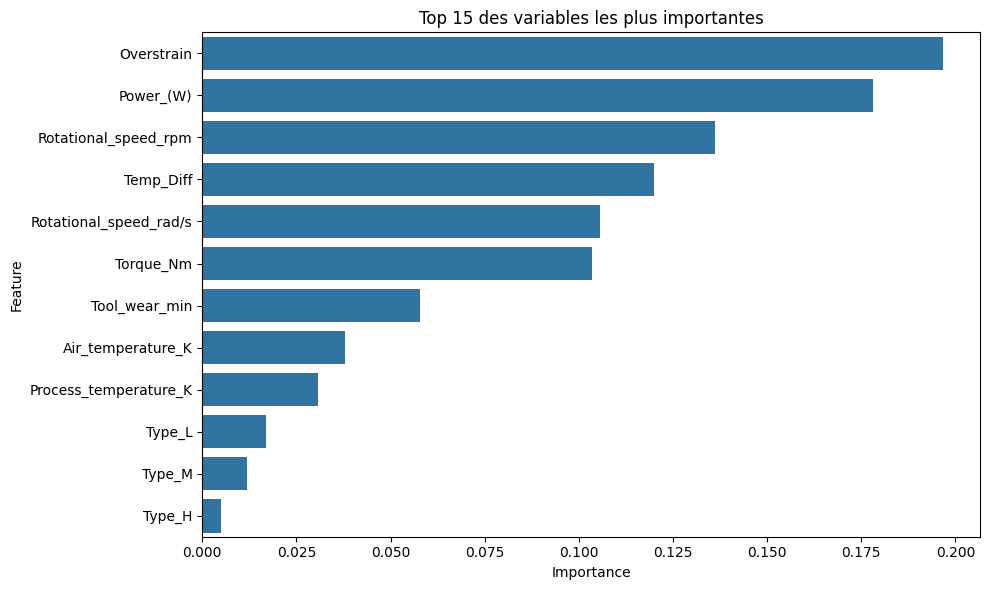

                   Feature  Importance
8               Overstrain    0.196684
7                Power_(W)    0.178189
2     Rotational_speed_rpm    0.136104
5                Temp_Diff    0.119875
6   Rotational_speed_rad/s    0.105490
3                Torque_Nm    0.103476
4            Tool_wear_min    0.057801
0        Air_temperature_K    0.037978
1    Process_temperature_K    0.030653
10                  Type_L    0.016793
11                  Type_M    0.012008
9                   Type_H    0.004950


In [ ]:
importances = rf_model.feature_importances_
features = X_train.columns


importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 des variables les plus importantes")
plt.tight_layout()
plt.show()

print(importance_df)

**Analyse Overfitting/Underfitting**

In [ ]:

def evaluation(model):
  model.fit(X_train,y_train)
  ypred=model.predict(X_test)
  print(classification_report(y_test,ypred))
  print(confusion_matrix(y_test,ypred))

  N, train_score, val_score = learning_curve(model,X_train,y_train,cv=4,scoring='f1',train_sizes=np.linspace(0.1,1,10))
  plt.figure(figsize=(12,8))
  plt.plot(N,train_score.mean(axis=1),label='train_score')
  plt.plot(N,val_score.mean(axis=1),label='train_score')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.96      0.81      0.88        68

    accuracy                           0.99      2000
   macro avg       0.98      0.90      0.94      2000
weighted avg       0.99      0.99      0.99      2000

[[1930    2]
 [  13   55]]


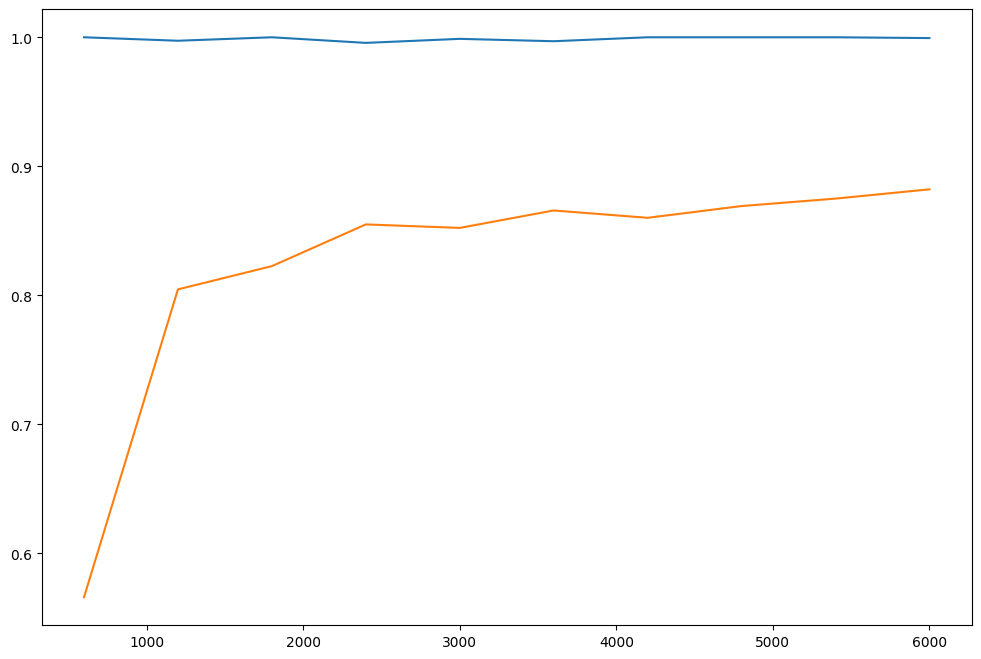

In [ ]:
evaluation(rf_model)

In [ ]:
print("Train score :", rf_model.score(X_train, y_train))
print("Test score :", rf_model.score(X_test, y_test))


Train score : 0.999875
Test score : 0.9925


Pad d'overfitting flagrant,

In [ ]:
rf_model_balanced = RandomForestClassifier(n_estimators=50, random_state=42,class_weight='balanced')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.96      0.75      0.84        68

    accuracy                           0.99      2000
   macro avg       0.98      0.87      0.92      2000
weighted avg       0.99      0.99      0.99      2000

[[1930    2]
 [  17   51]]


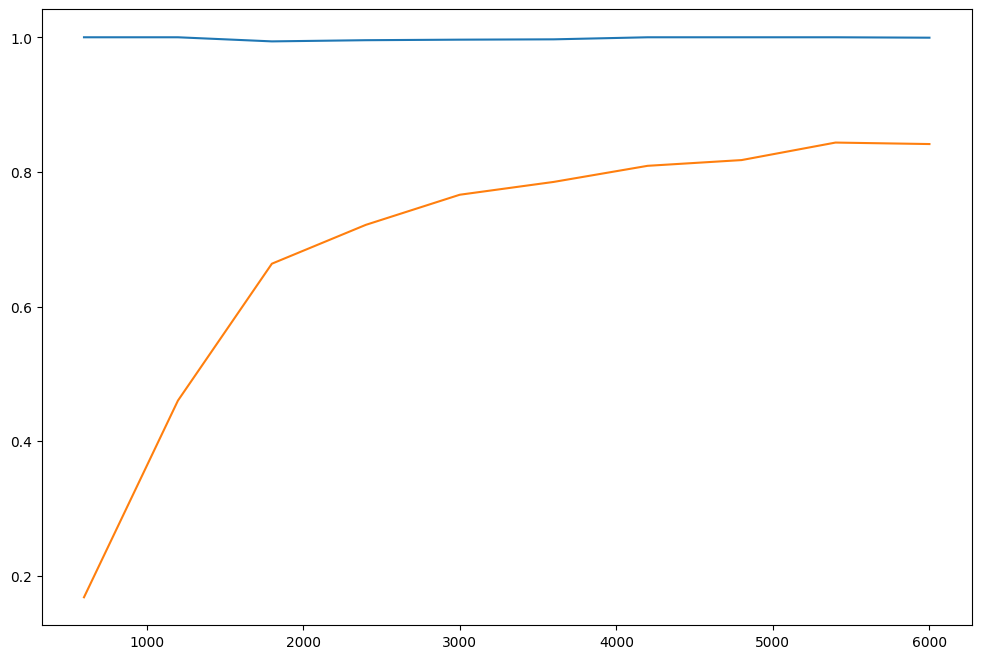

In [ ]:
evaluation(rf_model_balanced)

On essaie d'autres modeles

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.65      0.19      0.30        68

    accuracy                           0.97      2000
   macro avg       0.81      0.59      0.64      2000
weighted avg       0.96      0.97      0.96      2000

[[1925    7]
 [  55   13]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.83      0.35      0.49        68

    accuracy                           0.98      2000
   macro avg       0.90      0.68      0.74      2000
weighted avg       0.97      0.98      0.97      2000

[[1927    5]
 [  44   24]]


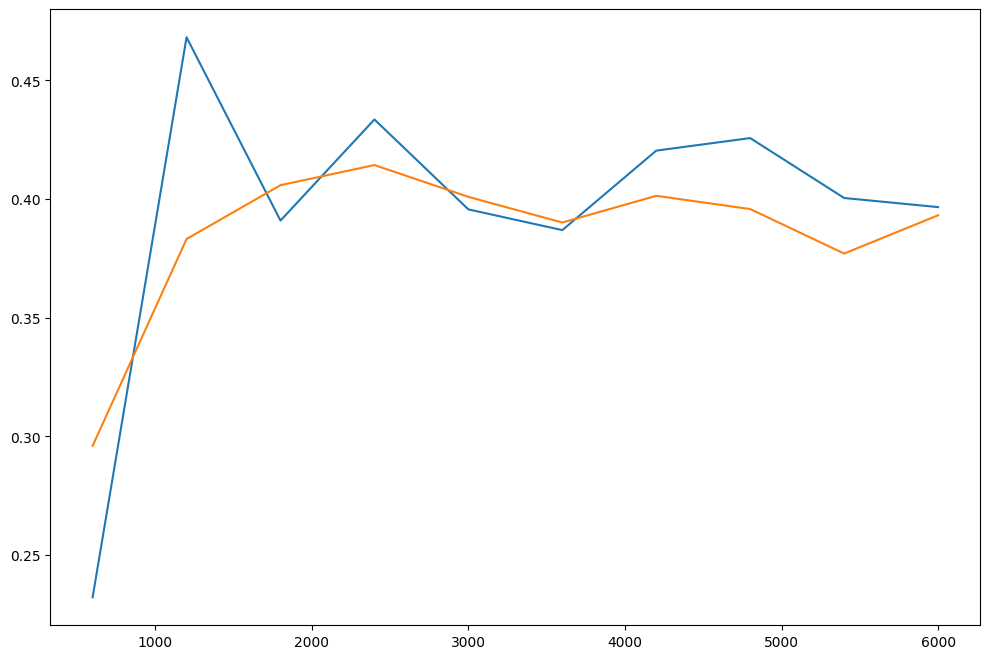

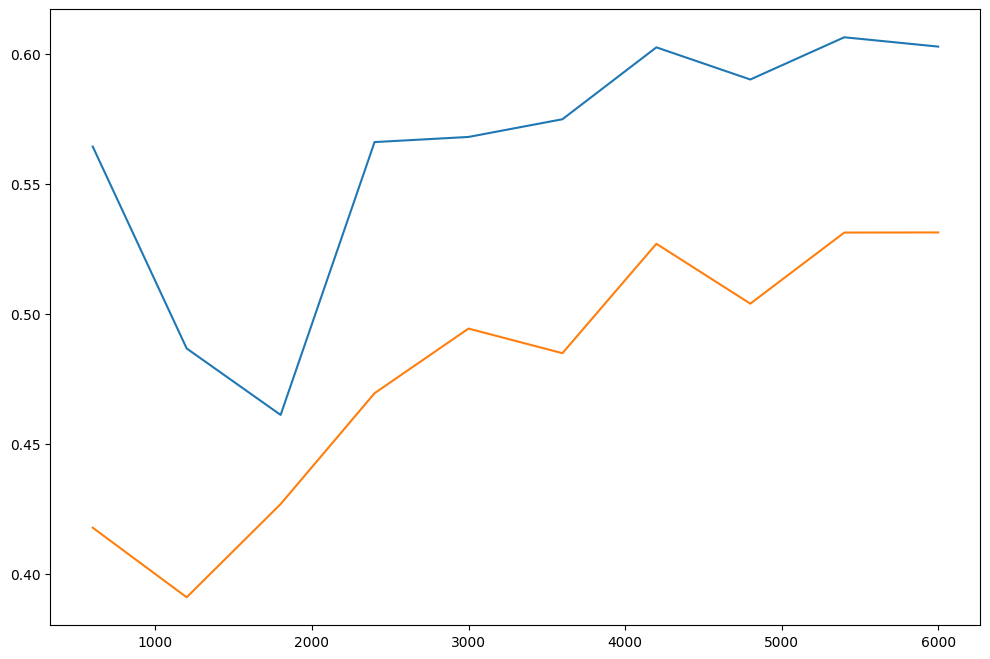

In [ ]:
lr = LogisticRegression( max_iter=5000, random_state=42)
evaluation(lr)


knn = KNeighborsClassifier(n_neighbors=5)
evaluation(knn)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.88      0.82      0.85        68

    accuracy                           0.99      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.99      0.99      0.99      2000

[[1924    8]
 [  12   56]]


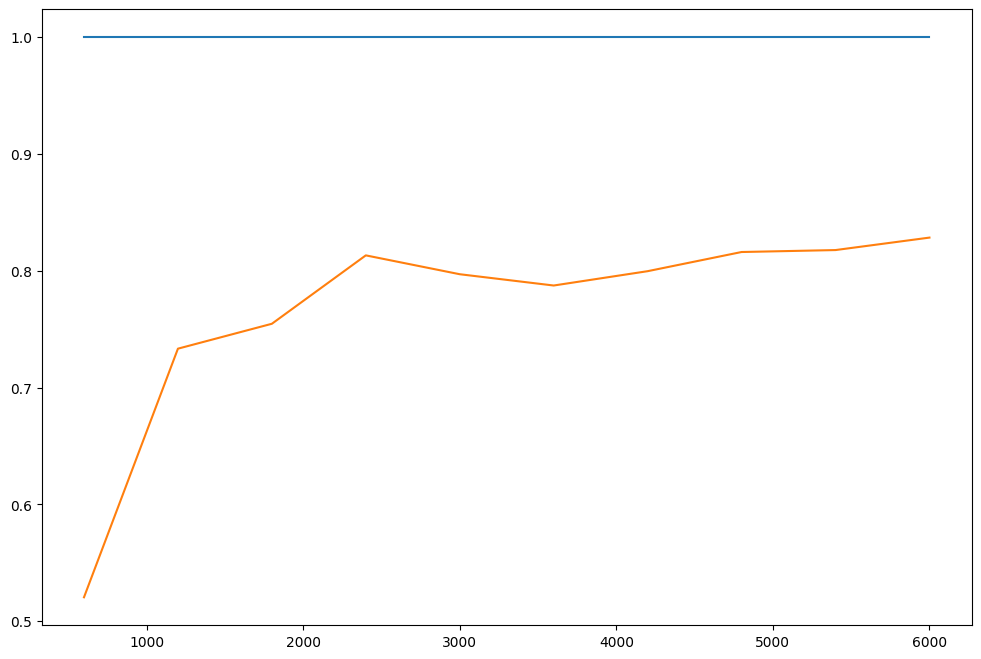

In [ ]:
xgb = XGBClassifier(
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='logloss',
    random_state=42
)

evaluation(xgb)

Donc Xgboost et Random forest sont bien meilleur que knn et logistic regression mais le score

Les deux modèles, Random Forest et XGBoost, obtiennent une excellente performance globale avec une accuracy de 99 % sur le jeu de test. Cependant, lorsqu’on se concentre sur la classe minoritaire (Machine failure = 1), des nuances apparaissent.

Le modèle **Random Forest** atteint une précision de 96 % et un F1-score de 88 % sur la classe 1, avec seulement 3 fausses alertes et 13 pannes non détectées. Il démontre ainsi une grande fiabilité dans ses prédictions positives, ce qui est idéal dans un contexte industriel où chaque alerte coûte cher.

Le modèle **XGBoost**, quant à lui, obtient une précision plus basse (88 %) mais un rappel légèrement supérieur (82 % vs 81 %), ce qui signifie qu’il détecte légèrement plus de pannes, au prix de quelques fausses alertes supplémentaires (8 faux positifs).



Dans L'industrie **panne manquée** coute plus cher  que de **détecter une fausse alerte** donc on va opter pour le Xgboost

**Sauvegarde du modele**

In [ ]:
joblib.dump(xgb, "xgb_model.joblib")

['xgb_model.joblib']

## Systéme de prédiction avec XGBoost

Pour s'assurer des noms des features de X

In [ ]:
X_train.columns

Index(['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm',
       'Torque_Nm', 'Tool_wear_min', 'Temp_Diff', 'Rotational_speed_rad/s',
       'Power_(W)', 'Overstrain', 'Type_H', 'Type_L', 'Type_M'],
      dtype='object')

In [ ]:



new_data = {
    'Air temperature [K]': 298.5,
    'Process temperature [K]': 308.7,
    'Rotational speed [rpm]': 1450,
    'Torque [Nm]': 38.5,
    'Tool wear [min]': 210,
    'Type_H': 0,
    'Type_L': 1,
    'Type_M': 0
}


input_df = pd.DataFrame([new_data])


input_df['Temp_Diff'] = input_df['Process temperature [K]'] - input_df['Air temperature [K]']
input_df['Rotational_speed_rad/s'] = input_df['Rotational speed [rpm]'] * (2 * np.pi / 60)
input_df['Power_(W)'] = input_df['Torque [Nm]'] * input_df['Rotational_speed_rad/s']
input_df['Overstrain'] = input_df['Tool wear [min]'] * input_df['Torque [Nm]']


input_df.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(' ', '_') for col in input_df.columns]


input_df = input_df[X_train.columns]


prediction = xgb.predict(input_df)[0]


print(" Panne prédite" if prediction == 1 else " Pas de panne prédite")


 Pas de panne prédite


In [ ]:
proba = xgb.predict_proba(input_df)[0][1]
print(f"Probabilité de panne : {proba:.2%}")


Probabilité de panne : 38.47%


##Prédiction type de panne

In [ ]:


X_multi = df.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'UDI', 'Product ID'], errors='ignore')
X_multi = pd.get_dummies(X_multi, columns=['Type'], drop_first=False)

X_multi['Temp_Diff'] = X_multi['Process temperature [K]'] - X_multi['Air temperature [K]']
X_multi['Rotational_speed_rad/s'] = X_multi['Rotational speed [rpm]'] * (2 * np.pi / 60)
X_multi['Power_(W)'] = X_multi['Torque [Nm]'] * X_multi['Rotational_speed_rad/s']
X_multi['Overstrain'] = X_multi['Tool wear [min]'] * X_multi['Torque [Nm]']


y_multi = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]


X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)



In [ ]:
model_multi = OneVsRestClassifier(RandomForestClassifier(random_state=42))
model_multi.fit(X_train_multi, y_train_multi)


OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [ ]:
y_pred_multi = model_multi.predict(X_test_multi)

print(classification_report(y_test_multi, y_pred_multi, target_names=y_multi.columns))


              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00        11
         HDF       0.94      1.00      0.97        17
         PWF       1.00      1.00      1.00        20
         OSF       1.00      1.00      1.00        18
         RNF       0.00      0.00      0.00         6

   micro avg       0.98      0.76      0.86        72
   macro avg       0.59      0.60      0.59        72
weighted avg       0.75      0.76      0.76        72
 samples avg       0.02      0.02      0.02        72



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

## Prediction avec nouvelles mesures .csv générées

In [ ]:


n = 20

types = np.random.choice(['L', 'M', 'H'], size=n, p=[0.5, 0.3, 0.2])


air_temp_normal = np.random.normal(loc=300, scale=2, size=n)
proc_temp_normal = air_temp_normal + 10 + np.random.normal(0, 1, size=n)
speed_normal = np.random.randint(1350, 1500, size=n)
torque_normal = np.random.normal(loc=40, scale=5, size=n).clip(20, 60)
wear_normal = np.random.randint(0, 200, size=n)


extreme_idx = np.random.choice(n, size=5, replace=False)
torque_normal[extreme_idx[0]] = 10   # sous-puissance
torque_normal[extreme_idx[1]] = 70   # sur-puissance
wear_normal[extreme_idx[2]] = 240    # usure max
proc_temp_normal[extreme_idx[3]] = air_temp_normal[extreme_idx[3]] + 5
speed_normal[extreme_idx[4]] = 1200  # vitesse trop basse

df_new = pd.DataFrame({
    'UDI': np.arange(1, n+1),
    'Product ID': [f"{types[i]}_{1000+i}" for i in range(n)],
    'Type': types,
    'Air temperature [K]': np.round(air_temp_normal, 2),
    'Process temperature [K]': np.round(proc_temp_normal, 2),
    'Rotational speed [rpm]': speed_normal,
    'Torque [Nm]': np.round(torque_normal, 2),
    'Tool wear [min]': wear_normal
})

df_new.to_csv("new_measurements.csv", index=False)
print(" Fichier 'new_measurements.csv' généré avec cas normaux + extrêmes")


 Fichier 'new_measurements.csv' généré avec cas normaux + extrêmes


In [ ]:
model.feature_names_in_

array(['Air_temperature_K', 'Process_temperature_K',
       'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Temp_Diff',
       'Rotational_speed_rad/s', 'Power_(W)', 'Overstrain', 'Type_H',
       'Type_L', 'Type_M'], dtype='<U22')

In [ ]:
model = joblib.load("xgb_model.joblib")


mesures = pd.read_csv("new_measurements.csv")


mesures.columns = mesures.columns.str.replace(' ', '_').str.replace('[', '').str.replace(']', '').str.replace('(', '').str.replace(')', '')



id_cols = mesures[['UDI', 'Product ID']] if 'Product ID' in mesures.columns else mesures[['UDI']]


mesures = pd.get_dummies(mesures, columns=["Type"], drop_first=False)


for col in ['Type_L', 'Type_M', 'Type_H']:
    if col not in df.columns:
        df[col] = 0


mesures['Temp_Diff'] = mesures['Process_temperature_K'] - mesures['Air_temperature_K']
mesures['Rotational_speed_rad/s'] = mesures['Rotational_speed_rpm'] * (2 * np.pi / 60)
mesures['Power_(W)'] = mesures['Torque_Nm'] * mesures['Rotational_speed_rad/s']
mesures['Overstrain'] = mesures['Tool_wear_min'] * mesures['Torque_Nm']


model_features = model.feature_names_in_
X_mes = mesures[model_features]

mes_result = id_cols.copy()
mes_result['Failure predicted'] = model.predict(X_mes)
mes_result['Failure probability'] = model.predict_proba(X_mes)[:, 1]

mes_result.to_csv("predicted_failures.csv", index=False)
print(" Prédictions enregistrées avec identifiants dans 'predicted_failures.csv'")


 Prédictions enregistrées avec identifiants dans 'predicted_failures.csv'
